# Generalized linear model on time bins
This notebook focus on modeling the heart rate. In this notebook, the heart rate won't be modeled by interbeats but by count time series. That means that the signal will be divided into time bins in which the number of heart beats that happened in registered.

In [1]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import logit

import sys
sys.path.append('../')
import FractalAnalysis as fa


from numpy import random
from tqdm import tqdm

## Utils

In [5]:
def get_beats(subject, abnormal=False):
    """
    Get the heart rate data for a given subject

    Arguments:
    - subject:  ID of the subject to get the heart rate. Must be of the format
                "group" + "number" + "nn". Where group is n (healthy), c 
                (congestive heart failure) or a (atrial fibrillation) and the
                number is between 1 and 5.
    - abnormal: True to print the proportion of abnormal beats (i.e. noisy 
                data), False otherwise

    Returns:
    - A numpy array with the heart rate (interbeats) signal
    """
    with open('../Heart-rates-disease/' + subject + '.txt') as f:
        lines = f.readlines()

    beats = []
    
    count_abnormal = 0
    count = 0

    for line in lines:
        line = line.split()
        if line[1] != "N":
            count_abnormal += 1
        beats.append(float(line[0]))
        count += 1
    
    if abnormal:
        print("Abnormal beats: ", count_abnormal/count*100, "%")
    return beats


def to_count_time_series(time_series, time_bin_size=0.001):
    """
    Transforms an interbeat signal into a count time series with time bins

    Arguments:
    - time_series: the heart rate signal to be transformed
    - time_bin_size: the size of the time bins

    Returns:
    - a count time series
    """

    # Compute the number of time bins
    total_time = sum(time_series)
    n_bins = int(total_time / time_bin_size) + 1

    # Initialize an array of zeros to hold the count for each time bin
    count_series = [0] * n_bins

    # Iterate over each time in the time series and increment the appropriate count bin
    cumulative_time = 0
    for t in time_series:
        cumulative_time += t
        bin_idx = int(cumulative_time / time_bin_size)
        count_series[bin_idx] += 1

    return count_series


def get_matrix(sig, n):
    """
    From a given heart rate signal, build the matrix X of the observations and
    the matrix Y of the resulting value. These matrix are then used to get the
    best parameters value for the GLM

    Arguments:
    - sig: the heart rate signal on which the GLM will be fitted
    - n: the number of observations to predict one value

    Returns:
    - X: the matrix of observations
    - Y: the values to be estimated

    """
    Y = sig[n:]
    X = [sig[i:i+n] for i in range(len(sig)-n+1)]
    X = X[:len(X)-1]
    X = np.asarray(X)

    X_offset = np.hstack((np.ones((len(Y),1)), X))

    return X, X_offset, Y


def GLM_fit(X_offset, Y, family):
    """
    Fit the GLM on given data

    Arguments:
    - X_offset: the matrix of observations
    - Y: the vector of the final value
    - family: the distribution of the exponential family used for the GLM

    Returns:
    - The constant parameter beta_0
    - The vector of parameters beta
    - The scale of the distribution 
    """

    glm_model = sm.GLM(endog=Y, exog=X_offset, family=family)
    GLM_results = glm_model.fit(max_iter=100, tol=1e-6, tol_criterion='params')

    GLM_const = GLM_results.params[0]
    GLM_filt = GLM_results.params[1:] # stimulus filter

    GLM_scale = GLM_results.scale

    return GLM_const, GLM_filt, GLM_scale


def link_log(theta):
    return np.exp(theta)

def link_logit(theta):
    return logit(theta)

## Fit the model

In [3]:
"""
- 1: Binomial
- 2: Poisson
"""

bin = sm.families.Binomial()
pois= sm.families.Poisson()
families = [bin, pois]
links = [link_logit, link_log]

In [9]:
exp_family = 1      # 0 for binomial, 1 for Poisson
subject = 'n1nn'    # Subject to be simulated
n = 1000            # number of observations
time_steps = 5        # Size of the time bins

sig = get_beats(subject)
new_sig = to_count_time_series(sig, time_bin_size=time_steps)

X, X_offset, Y = get_matrix(new_sig, n)


[8, 8, 8, 8, 7, 8, 8, 8, 8, 7, 9, 8, 8, 8, 8, 9, 9, 8, 8, 8, 9, 8, 7, 9, 7, 9, 8, 8, 8, 8, 8, 9, 8, 8, 8, 9, 8, 7, 8, 8, 8, 8, 8, 8, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 9, 8, 8, 9, 9, 9, 9, 8, 9, 10, 9, 9, 9, 10, 10, 10, 9, 9, 9, 9, 10, 9, 9, 9, 8, 8, 9, 8, 9, 9, 9, 10, 9, 9, 9, 9, 10, 9, 10, 10, 9, 10, 11, 10, 11, 10, 11, 11, 10, 11, 10, 11, 11, 10, 9, 10, 9, 10, 9, 6, 8, 8, 8, 8, 7, 7, 6, 8, 8, 7, 8, 6, 6, 6, 6, 7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 8, 8, 7, 8, 7, 7, 8, 7, 8, 7, 7, 6, 7, 7, 7, 7, 7, 7, 8, 6, 7, 7, 8, 7, 8, 8, 6, 7, 7, 7, 7, 6, 6, 7, 7, 7, 8, 7, 8, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 8, 7, 7, 8, 7, 6, 7, 8, 7, 8, 8, 7, 7, 6, 8, 8, 7, 7, 7, 7, 8, 7, 7, 7, 8, 7, 7, 8, 7, 7, 6, 7, 8, 7, 7, 7, 7, 8, 7, 8, 7, 8, 7, 8, 7, 7, 7, 8, 7, 8, 6, 8, 7, 7, 7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 6, 7, 7, 7, 8, 7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 8, 7, 8, 7, 7, 7, 7, 7, 7, 8, 7, 7, 7, 7, 8, 8, 7, 8, 7, 8, 7, 8, 7, 7, 8, 7, 7, 7, 8, 7, 8, 7, 7, 7, 6, 7, 7, 7, 8, 7, 7, 7, 7, 8, 7, 8, 7, 7, 7, 7, 8, 7, 6, 7, 

In [10]:
GLM_const, GLM_filt, GLM_scale = GLM_fit(X_offset, Y, families[exp_family])

theta = GLM_const + X @ GLM_filt
pred = links[exp_family](theta)

## Simulate a signal

100%|██████████| 15884/15884 [00:03<00:00, 4040.08it/s]


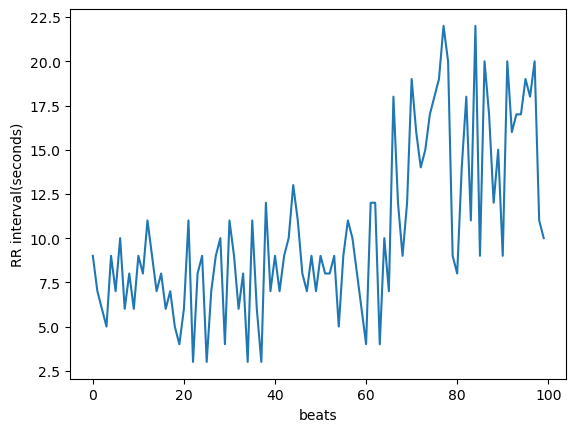

In [12]:
Num_points = len(new_sig)-1
generated_sig = np.zeros(Num_points)

X_i = X[0].tolist()

for i in tqdm(range(Num_points)):
    theta = GLM_const + X_i @ GLM_filt
    mu = links[exp_family](theta)
    value = random.poisson(lam=mu)
    if value > max(new_sig) + 10:
        value = new_sig[i]
    generated_sig[i] = value
    X_i = X_i[1:]
    X_i.append(value)


plt.plot(generated_sig[0:100])
plt.ylabel("RR interval(seconds)")
plt.xlabel("beats")
plt.show()

C:\Users\ophel\AppData\Local\Temp\ipykernel_3740\2497531379.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  mean_time = time_steps / el


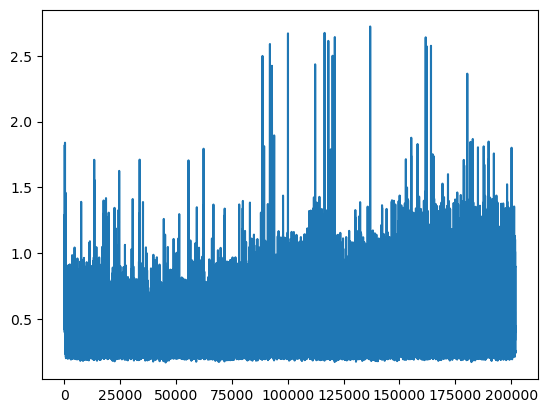

In [13]:
# Reproduce an interbeat signal from the count time series
final_generated_sig = []
for el in generated_sig:
    mean_time = time_steps / el
    for i in range(int(el)):
        final_generated_sig.append(random.normal(mean_time, mean_time/15))


plt.plot(final_generated_sig)

## Predict for the original signal

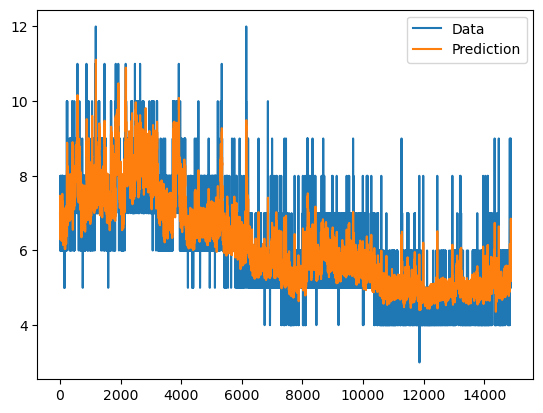

In [18]:
plt.plot(Y, label="Data")
plt.plot(pred, label="Prediction")

plt.legend()  
plt.show()

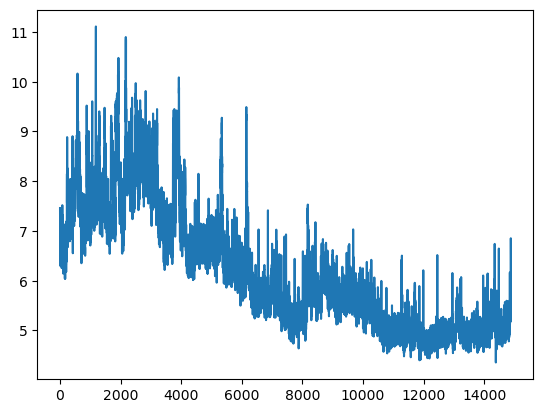

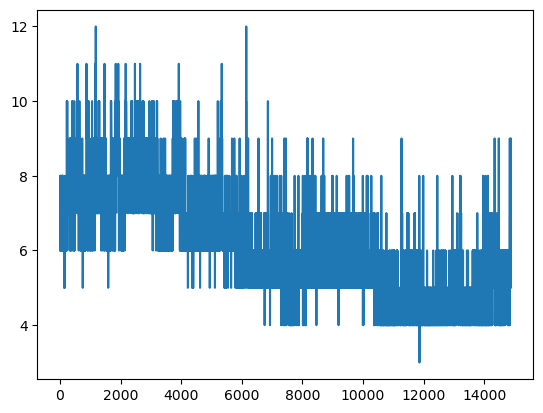

In [17]:
plt.plot(pred)
plt.show()
plt.plot(Y)
plt.show()